In [12]:
#Before a consumer places an order for delivery it is important to show them the expected delivery time.
#Consumer experience is important and affected by order lateness of delivery time or orders that are very early.
#I will build a model to predict the estimated time taken for a delivery.
#I will predict the total delivery duration seconds of an order, i.e., the time from
#● Start: the time consumer submits the order (`created_at`) to
#● End: when the order will be delivered to the consumer (`actual_delivery_time`).
#model
import pandas as pd
import numpy as np
import statistics
import sklearn
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from math import sqrt


from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report
#import graphviz

%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as scs
import scipy.stats as stats

import statsmodels.api as sm
from datetime import date, datetime, time

In [2]:
#Input and Read Data
#Input
df_historical=pd.read_csv('historical_data.csv')
df_predict=pd.read_csv('predict_data.csv')

#Read
df_historical
df_predict

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200
...,...,...,...,...,...,...,...,...,...
54773,1.0,2015-02-20 18:11:18,2956,1088,13.0,11.0,11.0,824.0,174203
54774,1.0,2015-02-21 21:01:44,2956,1824,26.0,26.0,32.0,477.0,138333
54775,1.0,2015-02-21 18:19:19,2956,2933,10.0,10.0,12.0,318.0,34110
54776,1.0,2015-02-19 23:43:26,2956,1438,12.0,12.0,18.0,593.0,178028


In [3]:
#####################Explore Data
#check data type
df_historical.info()
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

In [8]:
#change string object to date time object and calculate total delivery duration in seconds
time = ['created_at','actual_delivery_time']
for t in time:
    df_historical[t] = pd.to_datetime(df_historical[t])
df_predict['created_at'] = pd.to_datetime(df_predict['created_at'])

#I can calculate the actual delivery time in seconds
df_historical['actual_delivery_duration'] = df_historical['actual_delivery_time'] - df_historical['created_at']

df_historical['actual_delivery_duration_sec'] = df_historical['actual_delivery_duration'].dt.total_seconds()

#I will add day of the week, month, and hour since these are things that may affect dasher delivery times.
df_historical['create_Day'] = df_historical['created_at'].dt.dayofweek
df_historical['create_hr'] = df_historical['created_at'].dt.hour
df_historical['create_month'] = df_historical['created_at'].dt.month
df_predict['create_Day'] = df_predict['created_at'].dt.dayofweek
df_predict['create_hr'] = df_predict['created_at'].dt.hour
df_predict['create_month'] = df_predict['created_at'].dt.month



In [9]:
#Next I will check for any missing values or data that does not make sense.  
df_historical.isnull().sum().sort_values(ascending=False)

total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
market_id                                         987
estimated_store_to_consumer_driving_duration      526
actual_delivery_time                                7
actual_delivery_duration                            7
actual_delivery_duration_sec                        7
created_at                                          0
store_id                                            0
subtotal                                            0
create_Day                                          0
create_hr                                           0
create_month                                        0
dtype: int64

In [10]:
df_predict.isnull().sum().sort_values(ascending=False)

total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
market_id                                        250
estimated_store_to_consumer_driving_duration      11
created_at                                         0
store_id                                           0
subtotal                                           0
delivery_id                                        0
create_Day                                         0
create_hr                                          0
create_month                                       0
dtype: int64

<AxesSubplot:>

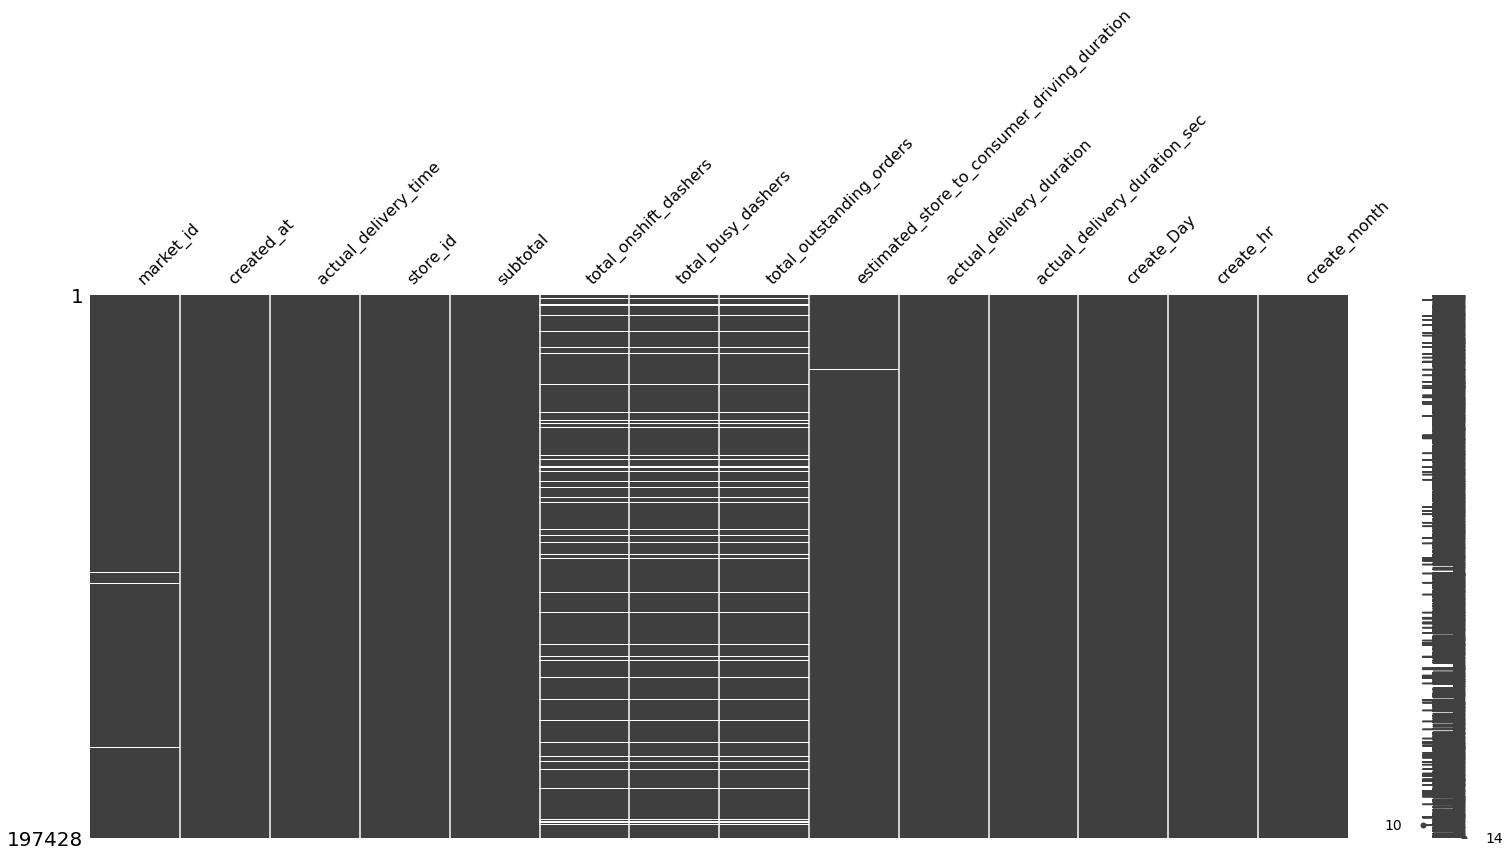

In [13]:
#I notice that some of the columns have the same number of missing values, so to see if they are connected I will graphically explore the missing values
#show missing values with white color on a matrix.
msno.matrix(df_historical)

In [14]:
# The total busy dashers and outstanding orders are a portion of the on shift dashers so it maks sense that what is causing the error causes it for all 3 values at the same time.

#Now that I know which values are missing I will do the following:
#1. Drop market ID (my be a system error) and actual delivery duration and duration in seconds (maybe the order was cancelled) that are missing.
#2.Since the total busy dashers and outstanding orders and on shift dashers are important and dominate the missing values, I can find the median of the other values to replace the missing value.
#3. I will leave estimated_store_to_consumer_driving_duration. This can vary due to traffic and area

In [15]:
#drop missing values from market ID
df_historical = df_historical[df_historical['market_id'].notna()]
df_predict = df_predict[df_predict['market_id'].notna()]

In [16]:
#drop missing values from actual_delivery_time
df_historical = df_historical[df_historical['actual_delivery_time'].notna()]

In [17]:
df_historical[df_historical['total_onshift_dashers'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,575,NaN,NaN,NaN,671.0,0 days 00:30:55,1855.0,4,1,2
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,1415,NaN,NaN,NaN,893.0,0 days 01:09:50,4190.0,5,2,2
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,650,NaN,NaN,NaN,479.0,0 days 00:57:02,3422.0,5,21,1
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,1550,NaN,NaN,NaN,1104.0,0 days 02:03:12,7392.0,6,3,2
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,1110,NaN,NaN,NaN,584.0,0 days 00:56:08,3368.0,4,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,1792,NaN,NaN,NaN,725.0,0 days 00:37:44,2264.0,1,19,2
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,2923,NaN,NaN,NaN,683.0,0 days 00:52:38,3158.0,4,3,2
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,3297,NaN,NaN,NaN,725.0,0 days 00:45:21,2721.0,4,3,1
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,2776,NaN,NaN,NaN,820.0,0 days 00:48:38,2918.0,5,3,1


In [23]:
# fill missing values with same market median
df_historical["total_onshift_dashers"].fillna(df_historical.groupby("market_id")["total_onshift_dashers"].transform("median"), inplace=True)
df_historical["total_busy_dashers"].fillna(df_historical.groupby("market_id")["total_busy_dashers"].transform("median"), inplace=True)
df_historical["total_outstanding_orders"].fillna(df_historical.groupby("market_id")["total_outstanding_orders"].transform("median"), inplace=True)

df_predict["total_onshift_dashers"].fillna(df_predict.groupby("market_id")["total_onshift_dashers"].transform("median"), inplace=True)
df_predict["total_busy_dashers"].fillna(df_predict.groupby("market_id")["total_busy_dashers"].transform("median"), inplace=True)
df_predict["total_outstanding_orders"].fillna(df_predict.groupby("market_id")["total_outstanding_orders"].transform("median"), inplace=True)



In [24]:
#Check the missing values again
df_historical.isnull().sum().sort_values(ascending=False)


estimated_store_to_consumer_driving_duration    525
market_id                                         0
created_at                                        0
actual_delivery_time                              0
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
actual_delivery_duration                          0
actual_delivery_duration_sec                      0
create_Day                                        0
create_hr                                         0
create_month                                      0
dtype: int64

In [25]:
df_predict.isnull().sum().sort_values(ascending=False)


estimated_store_to_consumer_driving_duration    11
market_id                                        0
created_at                                       0
store_id                                         0
subtotal                                         0
total_onshift_dashers                            0
total_busy_dashers                               0
total_outstanding_orders                         0
delivery_id                                      0
create_Day                                       0
create_hr                                        0
create_month                                     0
dtype: int64

In [26]:
#The Numerical Data can be explored further by looking to see if the numbers make sense. So now I will check the vlues for each category.
df_historical.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
count,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,195909.000000,196434,1.964340e+05,196434.000000,196434.000000,196434.000000
mean,2.978700,3530.472087,2682.366729,43.934395,41.023260,56.601383,545.299705,0 days 00:48:28.409155237,2.908409e+03,3.219682,8.468875,1.653095
std,1.524879,2053.184065,1823.156066,33.274698,30.967937,50.763001,219.345707,0 days 05:21:17.693369047,1.927769e+04,2.045671,8.659225,0.476371
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0 days 00:01:41,1.010000e+02,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1400.000000,18.000000,16.000000,18.000000,382.000000,0 days 00:35:04,2.104000e+03,1.000000,2.000000,1.000000
50%,3.000000,3591.500000,2200.000000,36.000000,35.000000,43.000000,544.000000,0 days 00:44:20,2.660000e+03,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,3395.000000,62.000000,59.000000,80.000000,702.000000,0 days 00:56:21,3.381000e+03,5.000000,19.000000,2.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,98 days 13:47:39,8.516859e+06,6.000000,23.000000,10.000000


In [27]:
df_predict.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,create_Day,create_hr,create_month
count,54528.000000,54528.000000,54528.000000,54528.000000,54528.000000,54528.000000,54517.000000,54528.000000,54528.000000,54528.000000,54528.0
mean,3.031360,3489.418519,2715.799369,48.342466,43.068442,61.403701,547.764275,126126.241491,3.225389,8.533524,2.0
std,1.531606,2050.326676,1897.476817,36.469734,33.053450,54.550679,220.487677,72695.462228,2.069217,8.717563,0.0
min,1.000000,2.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,20.000000,0.000000,0.000000,2.0
25%,2.000000,1661.000000,1420.000000,19.000000,16.000000,20.000000,385.000000,62923.500000,1.000000,2.000000,2.0
50%,3.000000,3518.000000,2220.000000,41.000000,36.000000,46.000000,544.000000,126215.000000,3.000000,3.000000,2.0
75%,4.000000,5248.000000,3415.000000,67.000000,60.000000,85.000000,703.000000,188935.500000,5.000000,19.000000,2.0
max,6.000000,6986.000000,29925.000000,175.000000,169.000000,292.000000,1550.000000,252031.000000,6.000000,23.000000,2.0


In [29]:
#Notice values for dashers and orders have a minimum<0 which does not mke sense. So all negative numbers will be replaced by 0
num = df_historical._get_numeric_data()
num[num < 0] = 0
df_historical.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
count,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,195909.000000,196434,1.964340e+05,196434.000000,196434.000000,196434.000000
mean,2.978700,3530.472087,2682.366729,43.934594,41.023453,56.602014,545.299705,0 days 00:48:28.409155237,2.908409e+03,3.219682,8.468875,1.653095
std,1.524879,2053.184065,1823.156066,33.274430,30.967672,50.762272,219.345707,0 days 05:21:17.693369047,1.927769e+04,2.045671,8.659225,0.476371
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:01:41,1.010000e+02,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1400.000000,18.000000,16.000000,18.000000,382.000000,0 days 00:35:04,2.104000e+03,1.000000,2.000000,1.000000
50%,3.000000,3591.500000,2200.000000,36.000000,35.000000,43.000000,544.000000,0 days 00:44:20,2.660000e+03,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,3395.000000,62.000000,59.000000,80.000000,702.000000,0 days 00:56:21,3.381000e+03,5.000000,19.000000,2.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,98 days 13:47:39,8.516859e+06,6.000000,23.000000,10.000000


In [30]:
num_test = df_predict._get_numeric_data()
num_test[num_test < 0] = 0
df_predict.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,create_Day,create_hr,create_month
count,54528.000000,54528.000000,54528.000000,54528.000000,54528.000000,54528.000000,54517.000000,54528.000000,54528.000000,54528.000000,54528.0
mean,3.031360,3489.418519,2715.799369,48.342503,43.068809,61.404508,547.764275,126126.241491,3.225389,8.533524,2.0
std,1.531606,2050.326676,1897.476817,36.469684,33.052959,54.549736,220.487677,72695.462228,2.069217,8.717563,0.0
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,2.0
25%,2.000000,1661.000000,1420.000000,19.000000,16.000000,20.000000,385.000000,62923.500000,1.000000,2.000000,2.0
50%,3.000000,3518.000000,2220.000000,41.000000,36.000000,46.000000,544.000000,126215.000000,3.000000,3.000000,2.0
75%,4.000000,5248.000000,3415.000000,67.000000,60.000000,85.000000,703.000000,188935.500000,5.000000,19.000000,2.0
max,6.000000,6986.000000,29925.000000,175.000000,169.000000,292.000000,1550.000000,252031.000000,6.000000,23.000000,2.0


subtotal


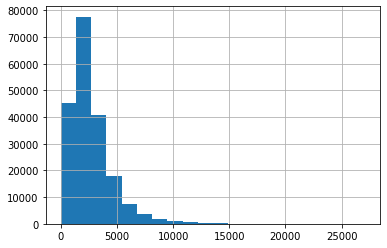

total_onshift_dashers


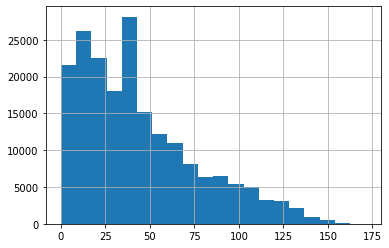

total_busy_dashers


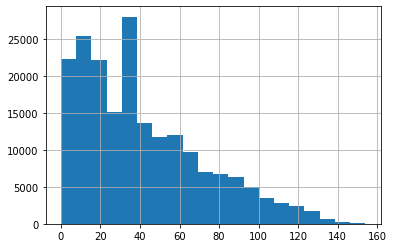

total_outstanding_orders


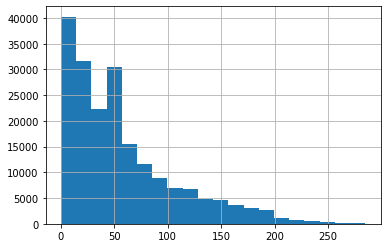

actual_delivery_duration_sec


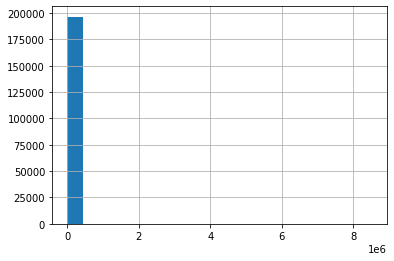

In [40]:
#To better observe data I can graph it and visually understand.
#I graph histograms of the data to gather insights

Num_column = ['subtotal', 'total_onshift_dashers','total_busy_dashers','total_outstanding_orders','actual_delivery_duration_sec']

for num in (Num_column):
    print(num)
    hist = df_historical[num].hist(bins=20)
    plt.show()



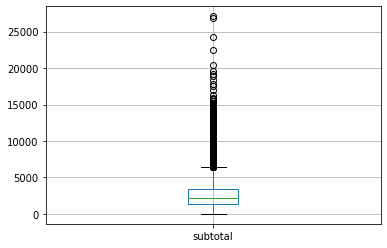

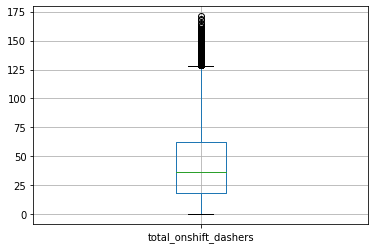

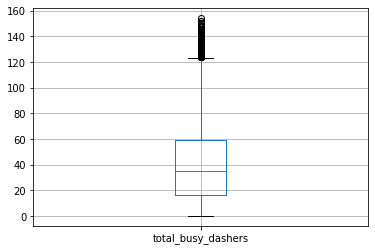

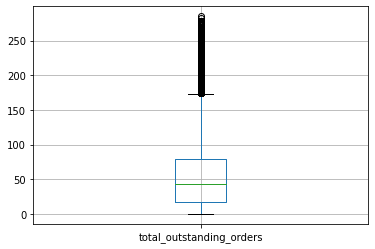

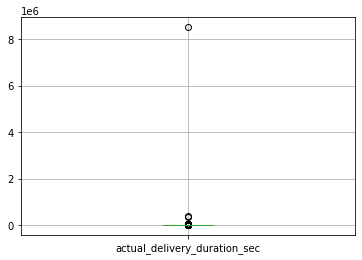

In [41]:
#The greater the price (subtotal) the less the orders.  The number of orders within 10 miles of the order being processed is usually smaller so the deliveries are successfully being delivered or being canceled because the dasher is too slow.
#The actual delivery duration in seconds seems to be low.

#Next we can see if there is any anomolies in the data by ploting box plots and seeking outliers.
Numerical_column = ['subtotal', 'total_onshift_dashers','total_busy_dashers','total_outstanding_orders','actual_delivery_duration_sec']
for i in (Numerical_column):
    df_historical.boxplot(column=[i])
    plt.show()


In [42]:
#Actual delivery duration has one very obvious outlier so I will remove it as it represents some issue that may have occured at the restaurant or a delay with finding a dasher or while traveling.
df_historical['actual_delivery_duration_sec'].max()


8516859.0

In [43]:
df_historical[df_historical['actual_delivery_duration_sec'] == 8516859]


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,1695,19.0,18.0,22.0,412.0,98 days 13:47:39,8516859.0,6,5,10


In [44]:
df_historical = df_historical.drop([2690])

<AxesSubplot:>

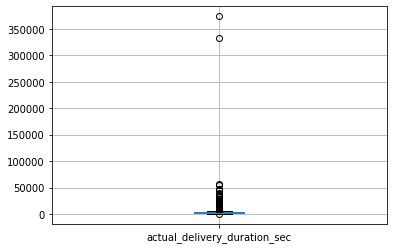

In [45]:
#Check the boxplot for actual delivery duration again.
df_historical.boxplot(column='actual_delivery_duration_sec')


In [46]:
#Now I observe two other outliers that I will drop.
df_historical['actual_delivery_duration_sec'].max()


373879.0

In [47]:
df_historical[df_historical['actual_delivery_duration_sec'] == 373879]


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
185550,4.0,2015-01-28 08:34:06,2015-02-01 16:25:25,6503,1520,0.0,0.0,0.0,476.0,4 days 07:51:19,373879.0,2,8,1


In [48]:
df_historical = df_historical.drop([185550])

In [49]:
df_historical['actual_delivery_duration_sec'].max()


332482.0

In [50]:
df_historical[df_historical['actual_delivery_duration_sec'] == 332482]


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
27189,1.0,2015-02-16 02:24:09,2015-02-19 22:45:31,4338,4980,72.0,68.0,104.0,767.0,3 days 20:21:22,332482.0,0,2,2


In [51]:
df_historical = df_historical.drop([27189])

<AxesSubplot:>

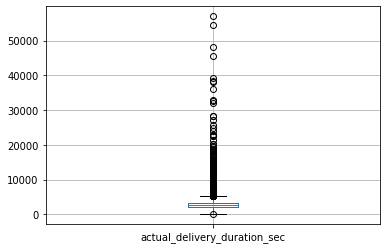

In [52]:
#Final check to ensure the outliers are removed.
df_historical.boxplot(column='actual_delivery_duration_sec')


In [53]:
#Now that the data has been cleaned, I will try to find noticeable patterns to begin the analysis of the data.
df_historical.corr()


,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
market_id,1.000000,0.017301,-0.016223,0.021722,0.020498,0.012198,0.006614,-0.046679,-0.002490,-0.013884,0.040430
store_id,0.017301,1.000000,-0.013464,-0.020573,-0.021123,-0.017695,0.002002,-0.010088,-0.000691,0.010135,0.003753
subtotal,-0.016223,-0.013464,1.000000,0.127779,0.122470,0.127171,0.034787,0.204312,0.032347,-0.184639,-0.006223
total_onshift_dashers,0.021722,-0.020573,0.127779,1.000000,0.944357,0.936867,0.043162,0.063680,0.097938,-0.356907,0.020432
total_busy_dashers,0.020498,-0.021123,0.122470,0.944357,1.000000,0.933489,0.041593,0.081950,0.082063,-0.333791,-0.047399
total_outstanding_orders,0.012198,-0.017695,0.127171,0.936867,0.933489,1.000000,0.037438,0.164697,0.083596,-0.344966,0.039401
estimated_store_to_consumer_driving_duration,0.006614,0.002002,0.034787,0.043162,0.041593,0.037438,1.000000,0.223169,0.007843,-0.023271,0.012018
actual_delivery_duration_sec,-0.046679,-0.010088,0.204312,0.063680,0.081950,0.164697,0.223169,1.000000,0.000339,-0.157863,0.061775
create_Day,-0.002490,-0.000691,0.032347,0.097938,0.082063,0.083596,0.007843,0.000339,1.000000,0.018964,-0.102268
create_hr,-0.013884,0.010135,-0.184639,-0.356907,-0.333791,-0.344966,-0.023271,-0.157863,0.018964,1.000000,-0.035485


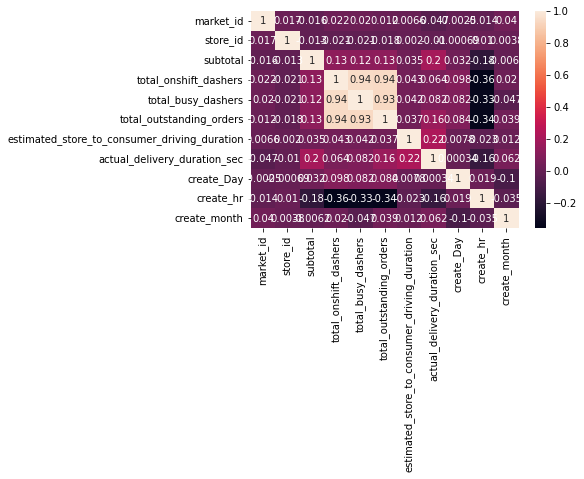

In [54]:
#covariance matrix plot
corrMatrix = df_historical.corr()
corr = sns.heatmap(corrMatrix, annot=True)

In [55]:
c = df_historical.corr()

s = c.unstack()
so = s.sort_values(kind="quicksort")
so

total_onshift_dashers     create_hr                  -0.356907
create_hr                 total_onshift_dashers      -0.356907
                          total_outstanding_orders   -0.344966
total_outstanding_orders  create_hr                  -0.344966
total_busy_dashers        create_hr                  -0.333791
                                                        ...   
total_onshift_dashers     total_onshift_dashers       1.000000
subtotal                  subtotal                    1.000000
store_id                  store_id                    1.000000
create_hr                 create_hr                   1.000000
create_month              create_month                1.000000
Length: 121, dtype: float64

<AxesSubplot:xlabel='market_id', ylabel='actual_delivery_duration_sec'>

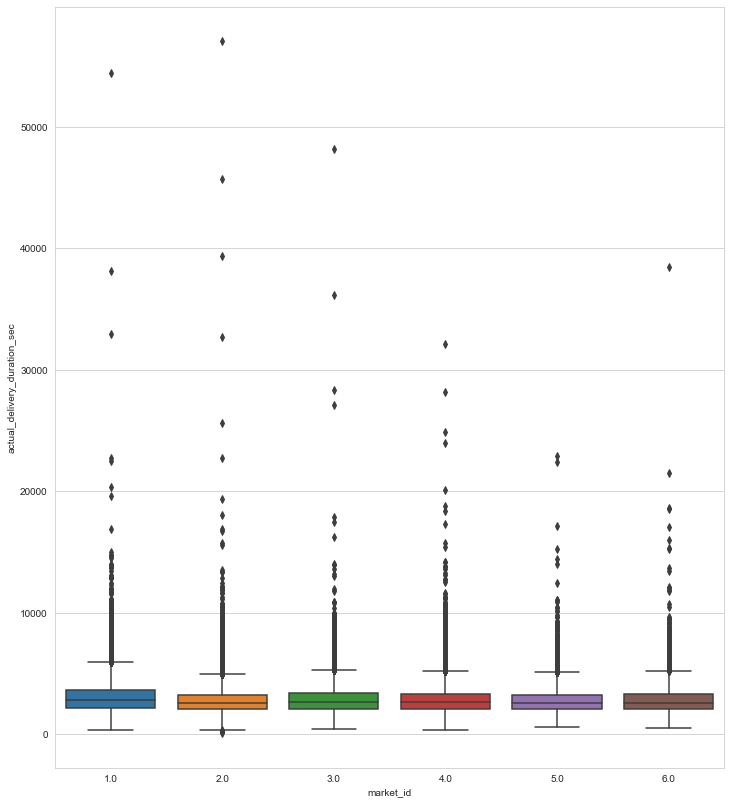

In [56]:
#High correlation is with create_hr and total_onshift_dashers; total_onshift_dashers with create_hr
#total_outstanding_orders with  create_hr and create_hr with total_outstanding_orders  
sns.set_style("whitegrid") 
plt.figure(figsize=(12,14))
sns.boxplot(x = 'market_id', y = 'actual_delivery_duration_sec', data = df_historical)


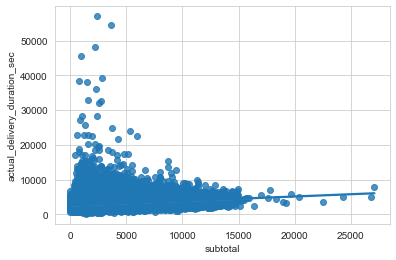

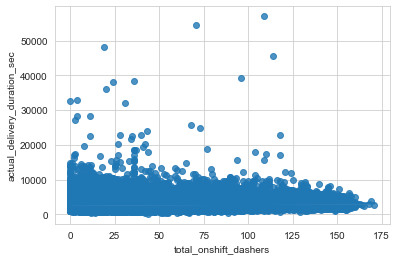

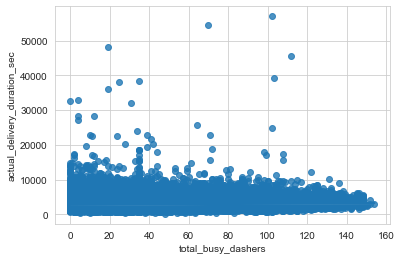

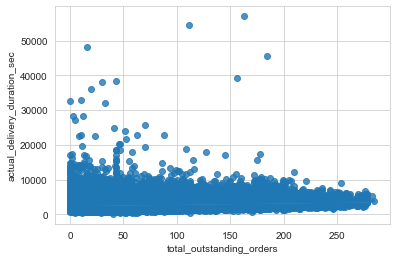

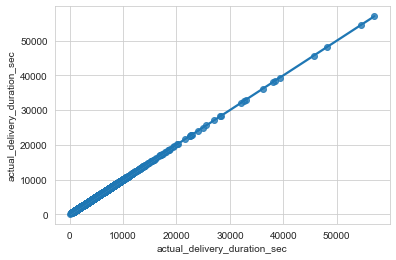

In [58]:
#Market ID doesn't seem to affect delivery time in seconds so if they are regions they are nearby

Numerical_column = ['subtotal', 'total_onshift_dashers','total_busy_dashers','total_outstanding_orders','actual_delivery_duration_sec']

for i in (Numerical_column):
    sns.regplot(x=i, y="actual_delivery_duration_sec", data=df_historical)
    plt.show()


<AxesSubplot:xlabel='create_Day'>

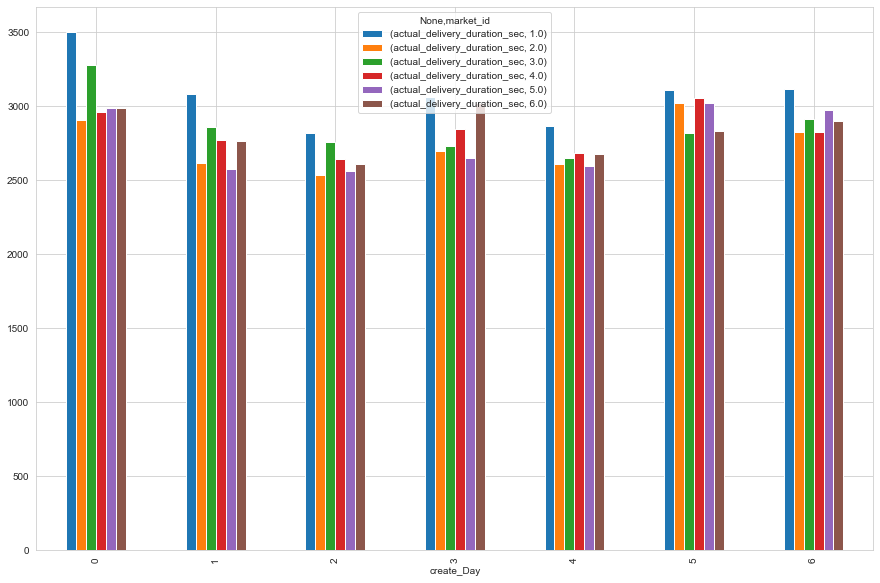

In [59]:
# The more dashers the faster the delivery duration.  The data looks very linear.

#Now I can observe how the delivery duration is affeced by the day of the week where 0-6 is Moonday throuhh Sunday respectively.
df_historical.groupby(["create_Day",'market_id']).mean()[['actual_delivery_duration_sec']].unstack('market_id').plot.bar(legend=True, figsize=(15,10))

<AxesSubplot:xlabel='create_hr'>

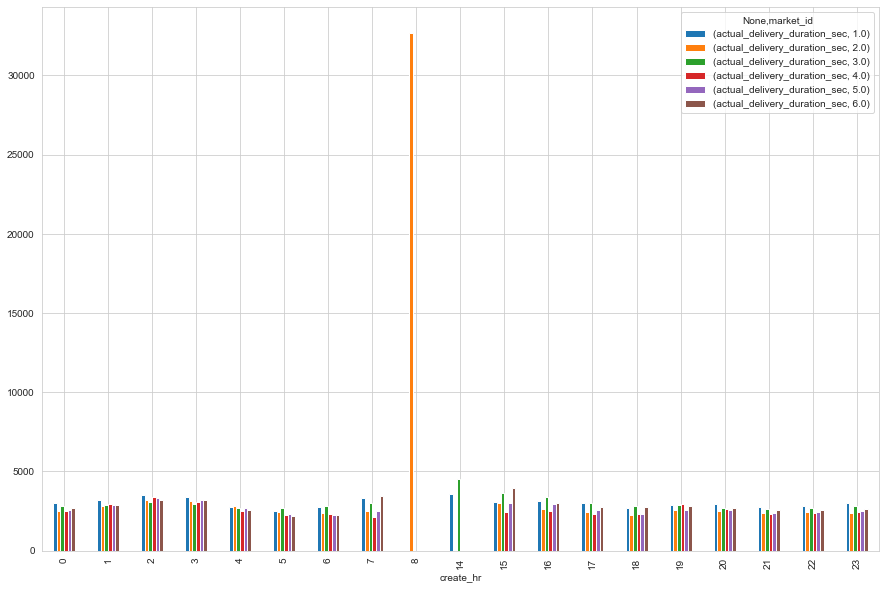

In [60]:
#Monday delivery times are the highest followed by the weekend.
df_historical.groupby(["create_hr",'market_id']).mean()[['actual_delivery_duration_sec']].unstack('market_id').plot.bar(legend=True, figsize=(15,10))

In [61]:
df_historical[(df_historical['create_hr'] == 8) & (df_historical['market_id'] == 2)]
#Here we see that market ID 2 at 8 am only has one delivery that took 32690 seconds or over 9 hours.  So we will view this as an outlier and remove it.

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,actual_delivery_duration,actual_delivery_duration_sec,create_Day,create_hr,create_month
63505,2.0,2015-01-24 08:19:17,2015-01-24 17:24:07,441,2740,0.0,0.0,0.0,730.0,0 days 09:04:50,32690.0,5,8,1


In [62]:
df_historical = df_historical.drop([63505])

<AxesSubplot:xlabel='create_hr'>

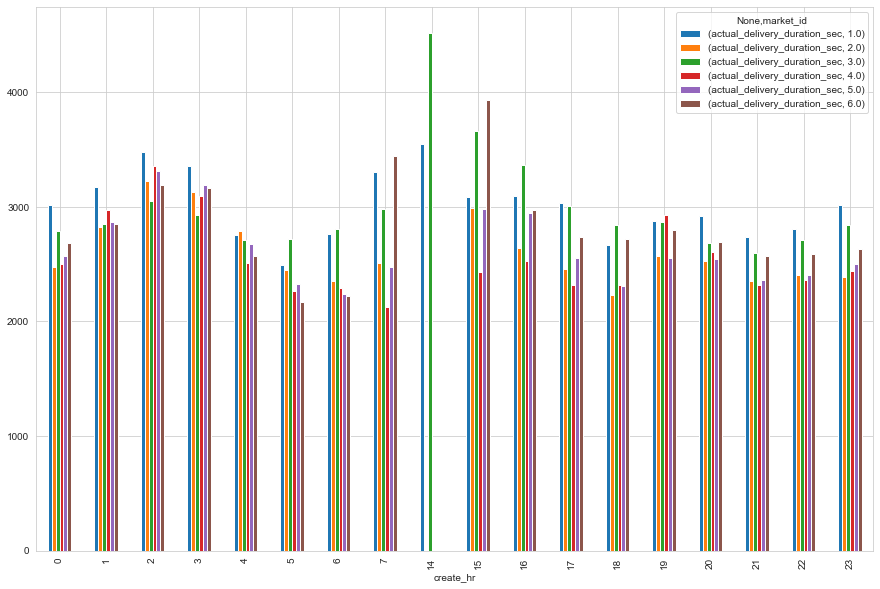

In [63]:
# This new graph shows the hours and delivery times without the anomaly.
df_historical.groupby(["create_hr",'market_id']).mean()[['actual_delivery_duration_sec']].unstack('market_id').plot.bar(legend=True, figsize=(15,10))

<AxesSubplot:xlabel='create_hr'>

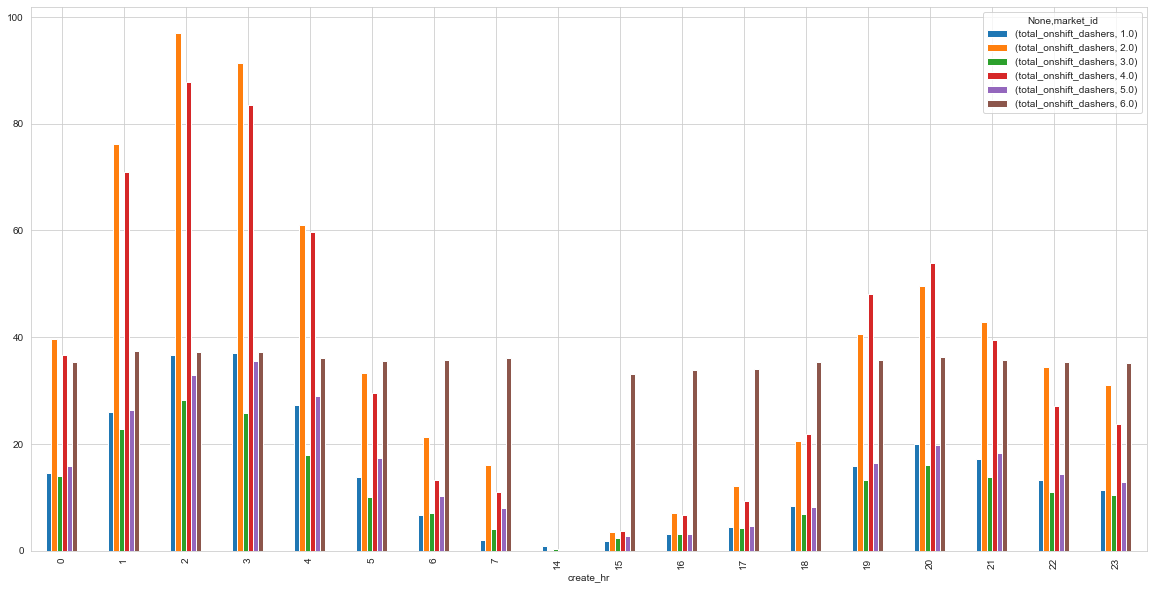

In [64]:
#The longest deliveries are at 2 and 3 pm.

df_historical.groupby(["create_hr",'market_id']).mean()[['total_onshift_dashers']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

In [66]:
##### Machine Learning Models
#Now that we were able to understand the importance of the different columns in understanding deliveries, we can include these columns in our model.
#Numerical data will be used to predict  solution so I will test 3 regressor models and choose the most accurate model
# separating data into training and test
X= df_historical.drop(columns=['actual_delivery_duration_sec','created_at', 'actual_delivery_time', 'actual_delivery_duration', 'estimated_store_to_consumer_driving_duration']) # cover_type is our target feature, which has 7 classes
y= df_historical['actual_delivery_duration_sec']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30,random_state=109)


# first, initialize the regressors
forest= RandomForestRegressor()
knn= KNeighborsRegressor(n_neighbors=1)
lin_reg=LinearRegression()

# now, create a list with the objects 
models=[lin_reg, forest, knn]

for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set                               
    print(f"Evaluate {type(model).__name__} Model:")
    print("Mean absolute error =", round(mean_absolute_error(y_test, y_pred), 2)) 
    print("Mean squared error =", round(mean_squared_error(y_test, y_pred), 2)) 
    print("Median absolute error =", round(median_absolute_error(y_test, y_pred), 2)) 
    print("\n")


Evaluate LinearRegression Model:
Mean absolute error = 744.3
Mean squared error = 1234297.91
Median absolute error = 596.2


Evaluate RandomForestRegressor Model:
Mean absolute error = 716.13
Mean squared error = 1158788.05
Median absolute error = 564.97


Evaluate KNeighborsRegressor Model:
Mean absolute error = 1044.71
Mean squared error = 2383191.67
Median absolute error = 772.0




In [67]:
# Evaluating the different Machine Learning Algorithms used for this data set the random forest regressor model was most accurate.  So it will be used to predict the actual delivery duration for the test data set.
# separating data into training and test
X= df_historical.drop(columns=['actual_delivery_duration_sec','created_at', 'actual_delivery_time', 'actual_delivery_duration', 'estimated_store_to_consumer_driving_duration']) # cover_type is our target feature, which has 7 classes
y=df_historical['actual_delivery_duration_sec'].astype('int64')
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30,random_state=109)


# first, initialize the regressors
forest= RandomForestRegressor()
forest.fit(X_train, y_train) # fit the model
test=df_predict.drop(columns=['created_at','delivery_id', 'estimated_store_to_consumer_driving_duration'])

df_predict['predicted_delivery_duration'] = forest.predict(test)#then predict on the test set
#print out the final prediction of delivery duration
print("Predictions for deliveries: ")
print(df_predict[['delivery_id','predicted_delivery_duration']])


Predictions for deliveries: 
       delivery_id  predicted_delivery_duration
0           194096                      2927.00
1           236895                      3124.63
2           190868                      3634.46
3           183076                      3069.55
4           186200                      3124.98
...            ...                          ...
54773       174203                      2626.23
54774       138333                      3013.00
54775        34110                      3377.28
54776       178028                      3103.65
54777       132824                      2961.63

[54528 rows x 2 columns]


In [68]:
df_predict.to_csv('data_to_predict.csv') #Create a file that includes the predicted delivery duration